In [1]:
import pandas as pd
import numpy as np

import torch

import data_utils.pulse as pulse #sean's code
import models.rf as models_rf
import models.fcnn as models_fcnn
import models.vae as models_vae

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)

In [3]:
#get the shot number from the test index
#(potential bug: pass the right df_input that has been used to create y_test. For example: df_input_clean)
def get_shot_num(shot_index,y_test,df_input):
    id_value=y_test.iloc[shot_index].name
    return(df_input['shot number'].loc[id_value])

## Read dataset

In [4]:
filename='datasets/galadriel_dataset_25_05_19_high_res.h5'

df_input=pd.read_hdf(filename,'df_input')#dazzler parameters + goodness
df_time=pd.read_hdf(filename,'df_time') #wizzler pulse shape data, first row is the time values

df_time_val=df_time.loc[0]
df_time= df_time.drop([0]) #drop the time values
df_time.reset_index(inplace=True,drop=True) #to start again from 0

#frequency, intesity and phase from the Wizzler (used to reconstruct pulse using Sean's code)
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

## Pulse reconstruction

Reconstruct the pulse shapes using Sean's code. This can take a couple of minutes

**Not done here**: Usually I write the reconstructed pulse shapes on a file in case I need to restart the notebook

In [5]:
#time in fs (it is the boundary)
def pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [6]:
%%time
t_200,df_pulse_200=pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=150,time_bins=200)

CPU times: user 44.7 s, sys: 6.05 ms, total: 44.7 s
Wall time: 45.6 s


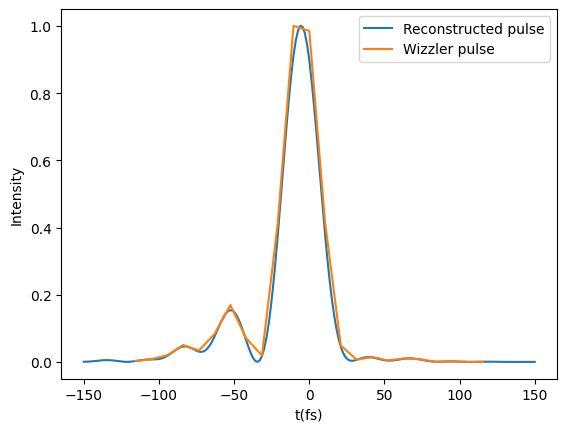

In [7]:
shot_index=35
plt.plot(t_200,df_pulse_200.iloc[shot_index],label='Reconstructed pulse')
plt.plot(df_time_val,df_time.iloc[shot_index],label='Wizzler pulse')
plt.xlabel('t(fs)')
plt.ylabel('Intensity')
plt.legend()

## Create the training/test datasets

(Here we should do some cleaning. Remove bad goodness shots....)

In [8]:
#DROP SHOTS witl low goodness
goodness_val=1.2
df_input_reduced=df_input[df_input['goodness']>goodness_val]

good_shots_list=df_input_reduced.index.values

df_pulse_200_reduced=df_pulse_200.iloc[good_shots_list]

#reset the index
df_input_reduced.reset_index(inplace=True,drop=True)
df_pulse_200_reduced.reset_index(inplace=True,drop=True)

In [9]:
#X: df_input (Dazzler parameters)
#Y: df_pulse (Pulse shapes)
X=df_input_reduced[['order2','order3','order4']]
y=df_pulse_200_reduced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [10]:
X_train

,order2,order3,order4
126,34400.0,13000.0,-4300000.0
174,34500.0,-17000.0,-5200000.0
381,34600.0,-8000.0,-4300000.0
915,34900.0,16000.0,-4300000.0
595,34700.0,7000.0,-5200000.0
...,...,...,...
575,34700.0,1000.0,-4900000.0
973,35000.0,-2000.0,-4900000.0
75,34400.0,-5000.0,-4300000.0
599,34700.0,7000.0,-4900000.0


## Model training (Forward)

### Random forest

In [11]:
def train_rf_forward(X_train, X_test, y_train, y_test):
    #Reset the index on y_test to have the same indexes as y_predict
    y_test_reset=y_test.reset_index(drop=True)

    #train forward model with Random forest
    #HYPERPARAMETERS
    n_estimators = 300
    max_features = 1.0#'sqrt'
    max_depth=20
    random_state=18

    forward_model_rf=models_rf.fit_random_forest(X_train,y_train,n_estimators, max_features,max_depth, random_state=18)

    y_predict_forward=models_rf.make_rf_prediction(forward_model_rf,X_test)

    #study the erro distribution
    #df_error_forward_rf=abs(y_test_reset-y_predict_forward)
    #df_error_forward_rf=df_error_forward_rf.sum(axis=1)/y_test.shape[1] #sum error / num columns

    return forward_model_rf

In [12]:
%%time
forward_model_rf=train_rf_forward(X_train, X_test, y_train, y_test)

CPU times: user 2.57 s, sys: 152 ms, total: 2.73 s
Wall time: 2.72 s


### Multi-layer perceptron (MLP)

In [13]:
device='cpu' #could be gpus if available
forward_model_mlp=models_fcnn.FWmodelNN(X_train,y_train,X_test,y_test,device)
forward_model_mlp.train(100,#epochs 
                 128,#batch size
                 10, #print freq
                 0.001) #learning rate
y_predict_nn_fwd=forward_model_mlp.predict(X_test)
error_fwd_model_mlp=forward_model_mlp.error_calc_mae()

Finished epoch 0,latest loss 0.06128185614943504
Finished epoch 10,latest loss 0.002170693362131715
Finished epoch 20,latest loss 0.001981149660423398
Finished epoch 30,latest loss 0.001273557310923934
Finished epoch 40,latest loss 0.0006122366175986826
Finished epoch 50,latest loss 0.00041324077756144106
Finished epoch 60,latest loss 0.00032845180248841643
Finished epoch 70,latest loss 0.0002773083106148988
Finished epoch 80,latest loss 0.0002443413541186601
Finished epoch 90,latest loss 0.00021724359248764813
Finished epoch 99,latest loss 0.00019859234453178942
Total time taken to train the model: 4.95s
Calculating the Mean Absolute Error


Text(0.5, 0, 'Epoch')

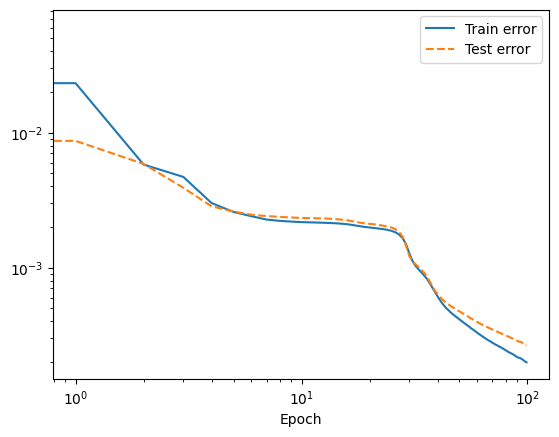

In [14]:
plt.plot(forward_model_mlp.train_error,label='Train error')
plt.plot(forward_model_mlp.test_error,linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

In [15]:
def plot_example(shot_index,X_test,y_test,df_input,df_time_val,
                 forward_model_rf,forward_model_mlp):
    #shot_index= is not the actual shot number but the index on the test set
    shot_numb=get_shot_num(shot_index,y_test,df_input)
    order2,order3,order4=X_test.iloc[shot_index].values
    
    X_values=pd.DataFrame([X_test.iloc[shot_index]])
    y_predict_forward_rf=models_rf.make_rf_prediction(forward_model_rf,X_values)
    y_predict_forward_nn=forward_model_mlp.predict(X_values)
    
    plt.plot(df_time_val,y_test.iloc[shot_index],label='Real shot (#'+str(shot_numb)+')',linewidth=3)
    plt.plot(df_time_val,y_predict_forward_rf[0],label='Prediction (RF)',linewidth=3,linestyle='--')
    plt.plot(df_time_val,y_predict_forward_nn[0],label='Prediction (MLP)',linewidth=3,linestyle='-.')
    
    mae_rf=abs(y_test.iloc[shot_index]-y_predict_forward_rf[0])
    mae_rf=mae_rf.sum()/len(y_test.iloc[shot_index])

    mae_mlp=abs(y_test.iloc[shot_index]-y_predict_forward_nn[0])
    mae_mlp=mae_mlp.sum()/len(y_test.iloc[shot_index])

    #mae='{:6.2f}'.format(100*mean_absolute_error(y_test.iloc[shot_index],y_predict_forward[shot_index]))
    plt.title('Forward predictions',fontsize=14)
    plt.text(45, 0.65, r'$\beta_2=$'+str(order2), dict(size=14))
    plt.text(45, 0.55, r'$\beta_3=$'+str(order3), dict(size=14))
    plt.text(45, 0.45, r'$\beta_4=$'+str(order4), dict(size=14))
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf))
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp))
    plt.xlabel('Time(fs)',fontsize=14)
    plt.ylabel('Intensity',fontsize=14)
    plt.legend()

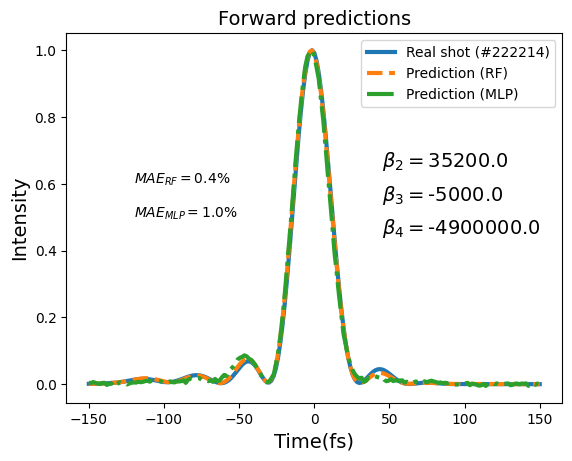

In [17]:
shot_index=120
plot_example(shot_index,X_test,y_test,df_input_reduced,t_200,
             forward_model_rf,forward_model_mlp)

# **** ROUNDTRIP MODELS  *****

### Random Forest

In [18]:
%%time
roundmodel_rf=models_rf.ROUNDmodelRF(X_train,X_test,y_train,y_test)
roundmodel_rf.train()
y_predict_round=roundmodel_rf.predict(y_test)

Training the Random Forest forward model
Training the Random Forest backward model
CPU times: user 53.9 s, sys: 158 ms, total: 54.1 s
Wall time: 54.1 s


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### MLP

In [19]:
#round model NN
roundmodel_mlp=models_fcnn.ROUNDmodelNN(X_train,y_train,X_test,y_test,device)
roundmodel_mlp.train(100,#epochs FWD
                 128,#batch size FWD
                 20, #print freq FWD
                 0.001, #learning rate FWF
                   400,#epochs  BWD
                 128,#batch size BWD
                 50, #print freq BWD
                 0.001) #learning rate BWD
y_predict_nn_round=roundmodel_mlp.predict(y_test)

Training the forward model
Finished epoch 0,latest loss 0.06370631605386734
Finished epoch 20,latest loss 0.0016348696080967784
Finished epoch 40,latest loss 0.0004047680995427072
Finished epoch 60,latest loss 0.0002918200334534049
Finished epoch 80,latest loss 0.00024048927298281342
Finished epoch 99,latest loss 0.0002073306095553562
Total time taken to train the model: 3.93s
Training the backward model
Finished epoch 0,latest loss 1.0211964845657349
Finished epoch 50,latest loss 0.2019123136997223
Finished epoch 100,latest loss 0.08198290318250656
Finished epoch 150,latest loss 0.06199028342962265
Finished epoch 200,latest loss 0.04767942801117897
Finished epoch 250,latest loss 0.03514896705746651
Finished epoch 300,latest loss 0.028612809255719185
Finished epoch 350,latest loss 0.028856221586465836
Finished epoch 399,latest loss 0.023815728724002838
Total time taken to train the model: 28.50s


Text(0.5, 0, 'Epoch')

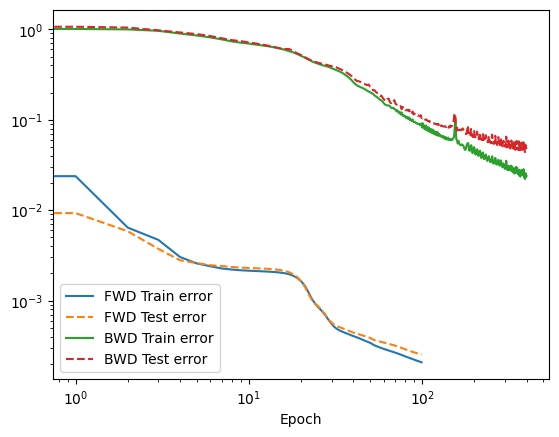

In [20]:
plt.plot(roundmodel_mlp.train_error_fwd,label='FWD Train error')
plt.plot(roundmodel_mlp.test_error_fwd,linestyle='--',label='FWD Test error')
plt.plot(roundmodel_mlp.train_error_bwd,label='BWD Train error')
plt.plot(roundmodel_mlp.test_error_bwd,linestyle='--',label='BWD Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

### CVAE

In [21]:
#define the model
total_in=len(t_200)+len(X_train.columns) #number of input: pulse+Dazz
out_dim=len(X_train.columns)#dazz coefficients
cvae=models_vae.ConditionalVAE(
    in_pulse_features=len(t_200),
    num_param=out_dim,
    latent_dim=10,
    hidden_dims_enc=[int(total_in*1.2),int(total_in),int(total_in/2),int(total_in/4)],
    hidden_dims_dec=[int(total_in*1.2),total_in,int(total_in*0.5),int(total_in/3),out_dim]
)
#if you want to see a description of the network
#batch_size = 10#just as an example
#y_length=len(t_200)
#x_length=len(X_train.columns)
#summary(cvae,[(batch_size,x_length),(batch_size,y_length)]) #from torchinfo import summary

In [22]:
model_cvae,train_error,test_error=models_vae.train_vae(y_train,y_test,X_train,X_test,
			cvae,device,n_epochs=300,batch_size=32,print_freq=20,learning_rate=0.002)

Training on: cpu
Finished epoch 0,latest loss 0.9182168841362
Finished epoch 20,latest loss 0.11120021343231201
Finished epoch 40,latest loss 0.09654883295297623
Finished epoch 60,latest loss 0.08951443433761597
Finished epoch 80,latest loss 0.07292985916137695
Finished epoch 100,latest loss 0.06754658371210098
Finished epoch 120,latest loss 0.06653714925050735
Finished epoch 140,latest loss 0.05354759469628334
Finished epoch 160,latest loss 0.04560214653611183
Finished epoch 180,latest loss 0.04200565069913864
Finished epoch 200,latest loss 0.033209074288606644
Finished epoch 220,latest loss 0.037864405661821365
Finished epoch 240,latest loss 0.030196048319339752
Finished epoch 260,latest loss 0.021462829783558846
Finished epoch 280,latest loss 0.019808586686849594
Finished epoch 299,latest loss 0.017713990062475204
Total time taken to train the model: 30.73s


Text(0.5, 0, 'Epoch')

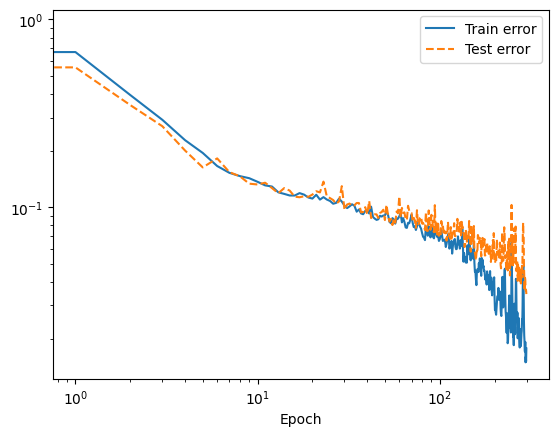

In [23]:
plt.plot(train_error[0],label='Train error')
plt.plot(test_error[0],linestyle='--',label='Test error')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Epoch')

## Testing the predictions from the Roundtrip models

In [24]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE. Uses a FWD RF to predict the pulse shape
# X_train in the input is the dataset used to normalized the X
def pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,y_test,device):
    #index_shot=150
    y_ex=y_test.iloc[index_shot]
    X_ex=X_test.iloc[index_shot]
    y_ex_tensor=torch.tensor(y_ex.values,dtype=torch.float32)
    print(len(y_ex))
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,len(y_ex)))
    print('Known Dazzler values',X_ex)

    shot_numb=get_shot_num(index_shot,y_test,df_input)


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]

    
    y_order2=np.linspace(0,1,10)
    x_order2=np.full_like(y_order2,X_ex['order2'])

    y_order3=np.linspace(0,1,10)
    x_order3=np.full_like(y_order3,X_ex['order3'])

    y_order4=np.linspace(0,1,10)
    x_order4=np.full_like(y_order4,X_ex['order4'])


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_rf=abs(y_ex-y_predict_round_rf)
    mae_rf=mae_rf.sum()/len(y_ex)

    mae_mlp=abs(y_ex-y_predict_round_nn_cust)
    mae_mlp=mae_mlp.sum()/len(y_ex)

    mae_cvae=abs(y_ex-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_ex)

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Real shot (#'+str(shot_numb)+')',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3,color='tab:orange')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3,color='tab:green')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3,color='tab:red')
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf),fontsize=16)
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp),fontsize=16)
    plt.text(-120,0.4,r'$MAE_{{CVAE}}={:.1f}$%'.format(100*mae_cvae),fontsize=16)
    plt.ylabel('Intensity',size=15)
    plt.xlabel('t(fs)',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order2,y_order2,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o2_rf,y_o2_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o2_nn,y_o2_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 1)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_x)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_x|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order3,y_order3,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o3_rf,y_o3_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o3_nn,y_o3_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 1)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=3,color='k')
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred $P(\beta_4|P^*)$',linewidth=4,color='tab:orange')
    plt.plot(x_order4,y_order4,linestyle=':',label='Real value',linewidth=3,color='tab:blue')
    plt.plot(x_o4_rf,y_o4_rf,linestyle='-',label='RF prediction',linewidth=3,color='tab:green')
    plt.plot(x_o4_nn,y_o4_nn,linestyle='-',label='MLP prediction',linewidth=3,color='tab:red')
    plt.xlabel(r'$\beta_4$',size=15)
    #plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

201
Known Dazzler values order2      34400.0
order3     -17000.0
order4   -4900000.0
Name: 26, dtype: float64


/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


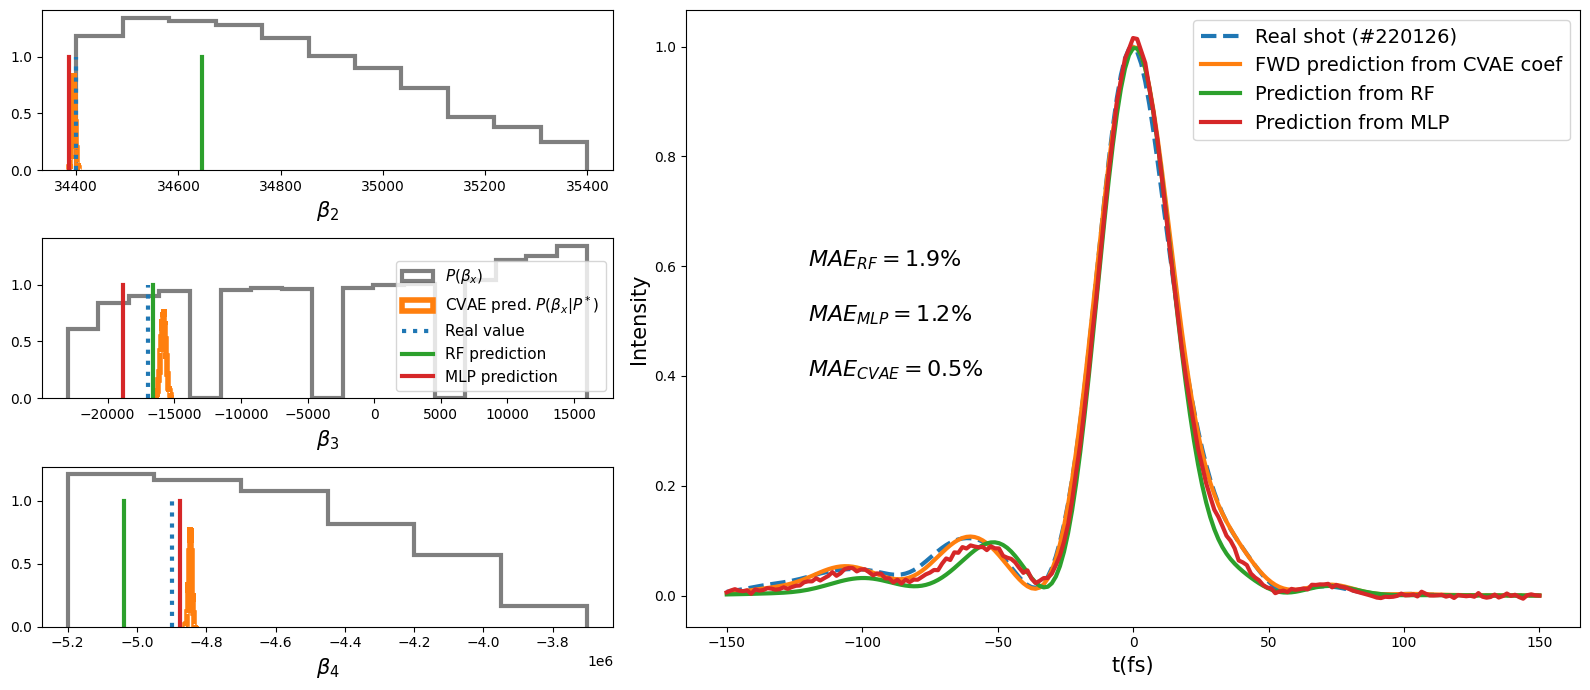

In [25]:
index_shot=106
pred_from_cvae(index_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,y_test,device)

# CUSTOM SHOTS

In [26]:
#Take a pulse shpae (y_ex) and get the predicted Dazz from CVAE and other models.
# X_train in the input is the dataset used to normalized the X
def pred_cust_cvae(y_ex,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodelNN,
                   df_input,t_200,X_train,device):
    y_ex_tensor=torch.tensor(y_ex,dtype=torch.float32)
    y_ex_tensor=torch.reshape(y_ex_tensor,(1,201))


    #Build the distributions functions P(D|p*)
    num_samples=10000
    dazz_norm=model_cvae.sample(num_samples,y_ex_tensor,device).detach().cpu().numpy()
    dazz_out=models_vae.renorm_data(dazz_norm,X_train)

    dist_order2=dazz_out[:,0]#dazz_out_list[:,0]
    dist_order3=dazz_out[:,1]#dazz_out_list[:,1]
    dist_order4=dazz_out[:,2]#dazz_out_list[:,2]


    num_bins=100

    weights_order2 = (num_bins/4)*np.ones_like(dist_order2) / len(dist_order2)
    weights_input2 = 10*np.ones_like(df_input['order2']) / len(df_input['order2'])

    weights_order3 = (num_bins/4)*np.ones_like(dist_order3) / len(dist_order3)
    weights_input3 = 14*np.ones_like(df_input['order3']) / len(df_input['order3'])

    weights_order4 = (num_bins/4)*np.ones_like(dist_order4) / len(dist_order4)
    weights_input4 = 5*np.ones_like(df_input['order4']) / len(df_input['order4'])

    #predictions from the RF roundtrip model
    y_predict_round_rf=roundmodel_rf.predict([y_ex])[0]
    X_predict_rf=roundmodel_rf.X_predict[0]
    
    y_o2_rf=np.linspace(0,1,10)
    x_o2_rf=np.full_like(y_o2_rf,X_predict_rf[0])

    y_o3_rf=np.linspace(0,1,10)
    x_o3_rf=np.full_like(y_o3_rf,X_predict_rf[1])

    y_o4_rf=np.linspace(0,1,10)
    x_o4_rf=np.full_like(y_o4_rf,X_predict_rf[2])

    #predictions from the NN roundtrip model
    y_predict_round_nn_cust=roundmodelNN.predict(pd.DataFrame([y_ex]))[0]
    X_predict_nn_cust=roundmodelNN.X_predict_nn[0]

    y_o2_nn=np.linspace(0,1,10)
    x_o2_nn=np.full_like(y_o2_nn,X_predict_nn_cust[0])

    y_o3_nn=np.linspace(0,1,10)
    x_o3_nn=np.full_like(y_o3_nn,X_predict_nn_cust[1])

    y_o4_nn=np.linspace(0,1,10)
    x_o4_nn=np.full_like(y_o4_nn,X_predict_nn_cust[2])

    #predictions from the CVAE generative model
    max_prob_o2_ind=np.argmax(np.histogram(dist_order2,bins=num_bins)[0]) #index of the maximum value in the P
    o2_pred=np.histogram(dist_order2,bins=num_bins)[1][max_prob_o2_ind]

    max_prob_o3_ind=np.argmax(np.histogram(dist_order3,bins=num_bins)[0]) #index of the maximum value in the P
    o3_pred=np.histogram(dist_order3,bins=num_bins)[1][max_prob_o3_ind]

    max_prob_o4_ind=np.argmax(np.histogram(dist_order4,bins=num_bins)[0]) #index of the maximum value in the P
    o4_pred=np.histogram(dist_order4,bins=num_bins)[1][max_prob_o4_ind]

    #print(o2_pred,o3_pred,o4_pred)
    y_pred_fwd_cvae=models_rf.make_rf_prediction(forward_model_rf,pd.DataFrame([(o2_pred,o3_pred,o4_pred)]))[0]

    mae_rf=abs(y_ex-y_predict_round_rf)
    mae_rf=mae_rf.sum()/len(y_ex)

    mae_mlp=abs(y_ex-y_predict_round_nn_cust)
    mae_mlp=mae_mlp.sum()/len(y_ex)

    mae_cvae=abs(y_ex-y_pred_fwd_cvae)
    mae_cvae=mae_cvae.sum()/len(y_ex)

    print('PREDICTIONS:')
    print('*Random Forest:')
    print(' -Order2:',X_predict_rf[0])
    print(' -Order3:',X_predict_rf[1])
    print(' -Order4:',X_predict_rf[2])
    print('*MLP:')
    print(' -Order2:',X_predict_nn_cust[0])
    print(' -Order3:',X_predict_nn_cust[1])
    print(' -Order4:',X_predict_nn_cust[2])
    print('*CVAE:')
    print(' -Order2:',o2_pred)
    print(' -Order3:',o3_pred)
    print(' -Order4:',o4_pred)

    plt.subplot(1,5,(3,5))#one row, 4 columns, spanning from the first to the third
    plt.plot(t_200,y_ex,label='Custom shot',linestyle='--',linewidth=3,color='tab:blue')
    plt.plot(t_200,y_pred_fwd_cvae,label='FWD prediction from CVAE coef',linewidth=3,color='tab:orange')
    plt.plot(t_200,y_predict_round_rf,label='Prediction from RF',linewidth=3,color='tab:green')
    plt.plot(t_200,y_predict_round_nn_cust,label='Prediction from MLP',linewidth=3,color='tab:red')
    plt.text(-120,0.6,r'$MAE_{{RF}}={:.1f}$%'.format(100*mae_rf),fontsize=16)
    plt.text(-120,0.5,r'$MAE_{{MLP}}={:.1f}$%'.format(100*mae_mlp),fontsize=16)
    plt.text(-120,0.4,r'$MAE_{{CVAE}}={:.1f}$%'.format(100*mae_cvae),fontsize=16)
    plt.xlabel('t(fs)',size=15)
    plt.ylabel('Intensity',size=15)
    plt.legend(fontsize=14)

    plt.subplot(3,5,(1,2))#(3, 2, 1)
    plt.hist(df_input['order2'],bins=11,weights=weights_input2,histtype="step",label=r'$P(\beta_2)$',alpha=0.5,linewidth=2,color='k')
    plt.hist(dist_order2,bins=num_bins,weights=weights_order2,histtype="step",label=r'CVAE pred. $P(\beta_2|P^*)$',linewidth=2,color='tab:orange')
    plt.plot(x_o2_rf,y_o2_rf,linestyle='-',label='RF prediction',linewidth=2,color='tab:green')
    plt.plot(x_o2_nn,y_o2_nn,linestyle='-',label='MLP prediction',linewidth=2,color='tab:red')
    plt.xlabel(r'$\beta_2$',size=15)
    #plt.legend(fontsize=11)

    plt.subplot(3,5,(6,7))#(3, 2, 2)
    plt.hist(df_input['order3'],bins=17,weights=weights_input3,histtype="step",label=r'$P(\beta_x)$',alpha=0.5,linewidth=2,color='k')
    plt.hist(dist_order3,bins=num_bins,weights=weights_order3,histtype="step",label=r'CVAE pred. $P(\beta_x|P^*)$',linewidth=2,color='tab:orange')
    plt.plot(x_o3_rf,y_o3_rf,linestyle='-',label='RF prediction',linewidth=2,color='tab:green')
    plt.plot(x_o3_nn,y_o3_nn,linestyle='-',label='MLP prediction',linewidth=2,color='tab:red')
    plt.xlabel(r'$\beta_3$',size=15)
    plt.legend(fontsize=11)

    plt.subplot(3,5,(11,12))#(3, 2, 3)
    plt.hist(df_input['order4'],bins=6,weights=weights_input4,histtype="step",label=r'$P(\beta_4)$',alpha=0.5,linewidth=2,color='k')
    plt.hist(dist_order4,bins=num_bins,weights=weights_order4,histtype="step",label=r'CVAE pred. $P(\beta_4|P^*)$',linewidth=2,color='tab:orange')
    plt.plot(x_o4_rf,y_o4_rf,linestyle='-',label='RF prediction',linewidth=2,color='tab:green')
    plt.plot(x_o4_nn,y_o4_nn,linestyle='-',label='MLP prediction',linewidth=2,color='tab:red')
    plt.xlabel(r'$\beta_4$',size=15)
    #plt.legend(fontsize=11)

    fig = plt.gcf()
    fig.set_size_inches(16, 7)
    fig.tight_layout()
    plt.show()

In [27]:
#define the curve to fit (the custom pulse shape)
# It's just 5 gaussians
def func(t,a0, a1,a2,
        b0,b1,b2,
        c0,c1,c2,
        d0,d1,d2,
        e0,e1,e2): 
    #envelope=1*np.exp(-((t-0)**2)/(2*30*30))
    return (a0*np.exp(-((t-a1)**2)/(2*a2*a2))
            +b0*np.exp(-((t-b1)**2)/(2*b2*b2))
           +c0*np.exp(-((t-c1)**2)/(2*c2*c2))
           +d0*np.exp(-((t-d1)**2)/(2*d2*d2))
           +e0*np.exp(-((t-e1)**2)/(2*e2*e2)))

The following cells are custom shots we can try

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS:
*Random Forest:
 -Order2: 34660.0
 -Order3: 6580.0
 -Order4: -4156000.0
*MLP:
 -Order2: 34391.43
 -Order3: 13540.355
 -Order4: -4502086.5
*CVAE:
 -Order2: 34481.574
 -Order3: 11416.91
 -Order4: -4714945.5


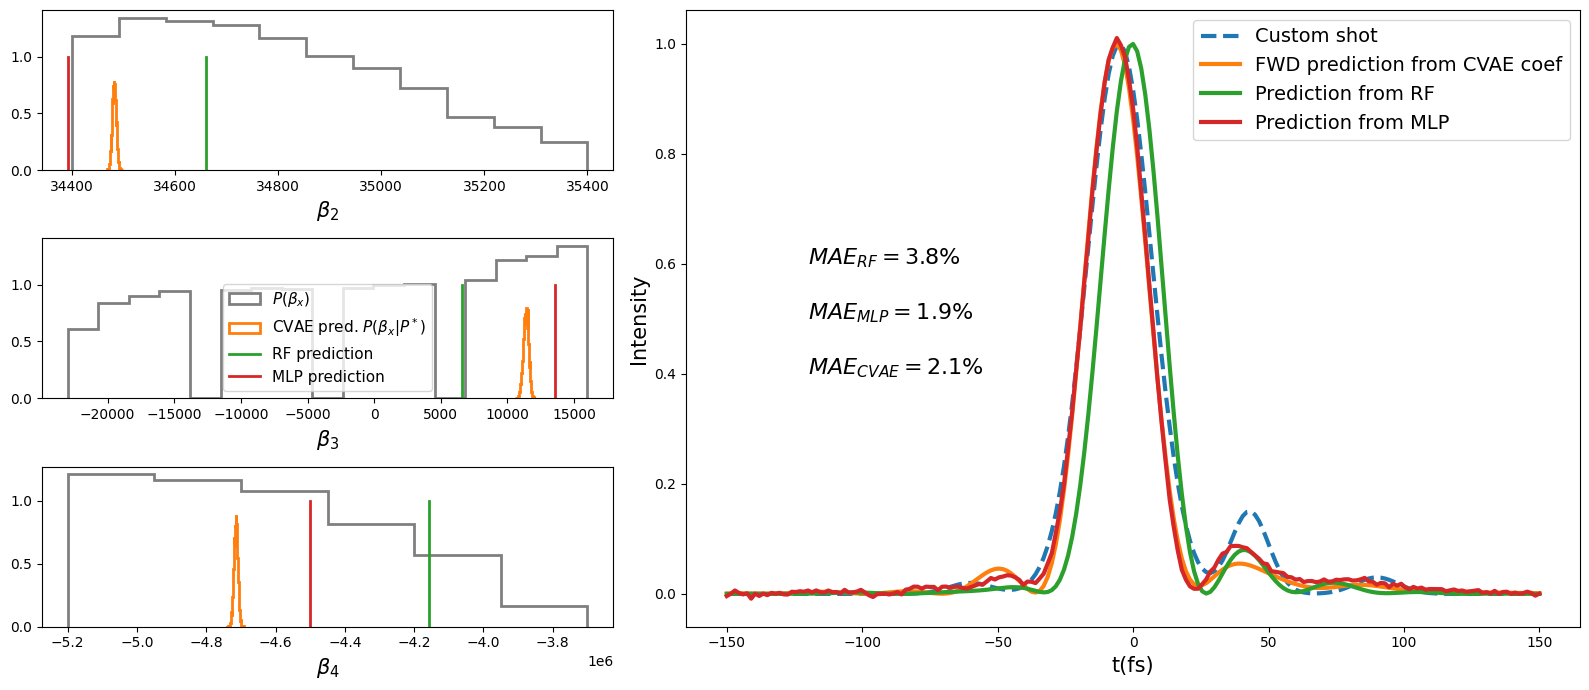

In [28]:
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.02,-60,8,
                 1,-5,12,
                 0.15,+43,7,
                 0.03,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS:
*Random Forest:
 -Order2: 34659.0
 -Order3: -1020.0
 -Order4: -4328000.0
*MLP:
 -Order2: 34242.953
 -Order3: 10768.639
 -Order4: -4354266.5
*CVAE:
 -Order2: 33991.082
 -Order3: 33993.492
 -Order4: -3903133.5


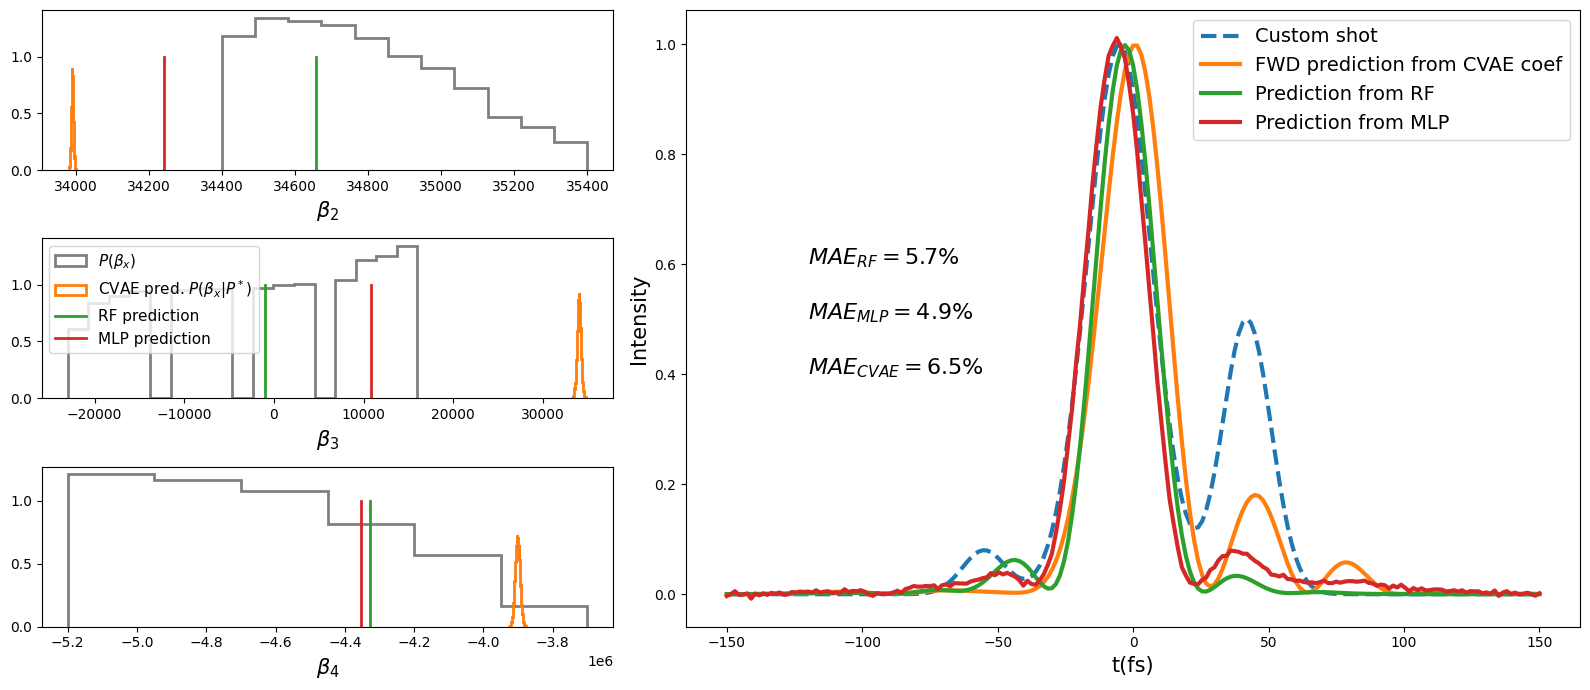

In [29]:
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.08,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS:
*Random Forest:
 -Order2: 34650.333333333336
 -Order3: -2110.0
 -Order4: -4320000.0
*MLP:
 -Order2: 34180.793
 -Order3: -8836.347
 -Order4: -4000805.0
*CVAE:
 -Order2: 33659.61
 -Order3: -9907.023
 -Order4: -2765516.5


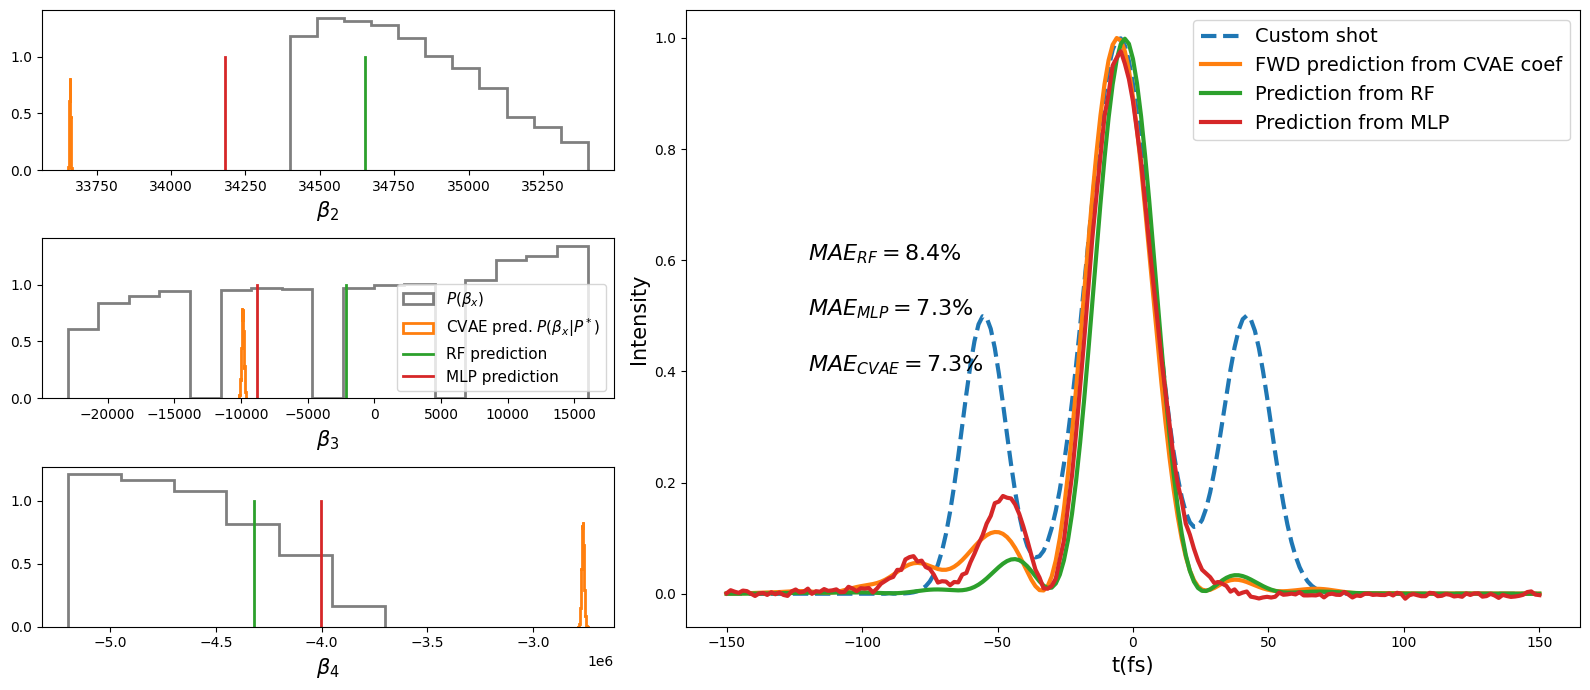

In [30]:
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.5,-55,8,
                 1,-5,12,
                 0.50,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS:
*Random Forest:
 -Order2: 34609.666666666664
 -Order3: -6430.0
 -Order4: -4144000.0
*MLP:
 -Order2: 34502.246
 -Order3: -15928.058
 -Order4: -3896165.5
*CVAE:
 -Order2: 34551.55
 -Order3: -19357.822
 -Order4: -3938606.2


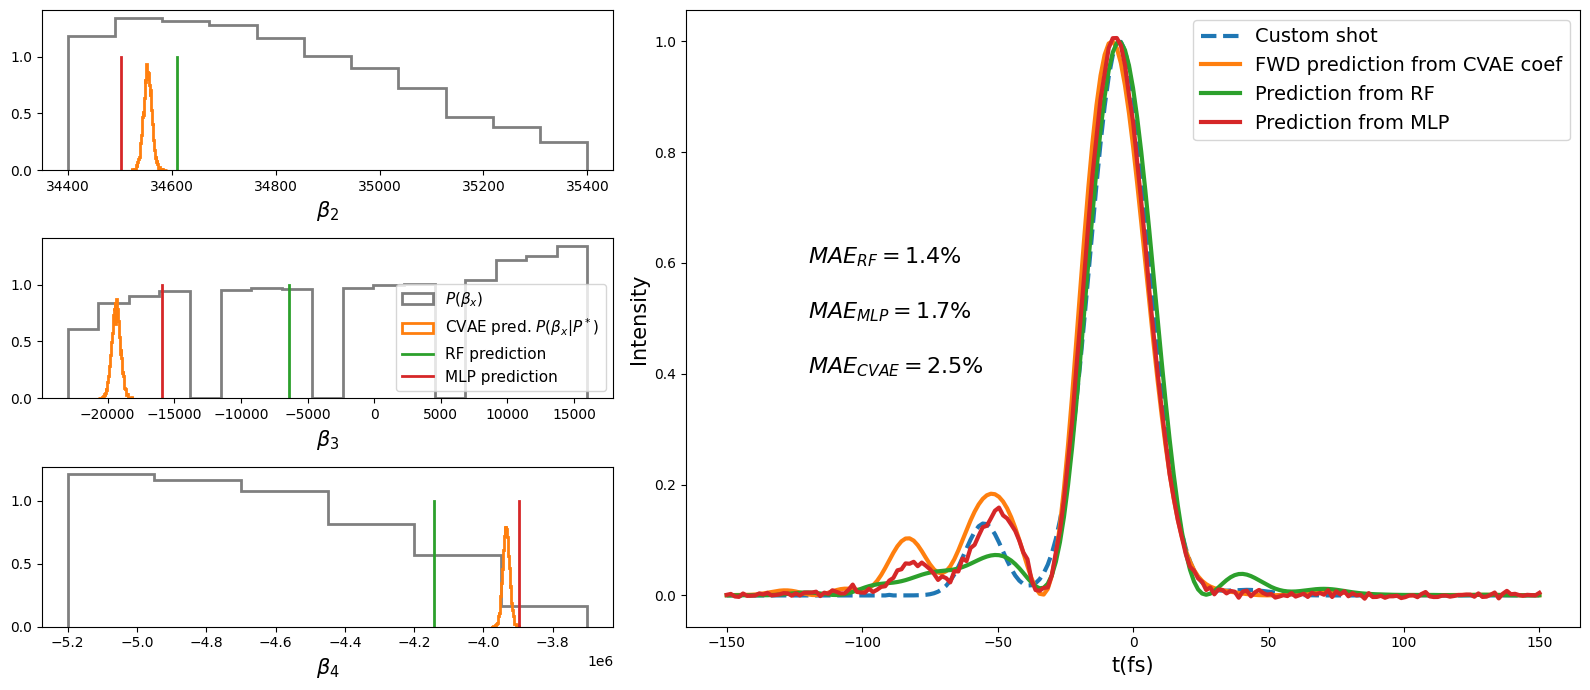

In [31]:
y_cust_shot=func(t_200,
                 0.001,-90,0.1,
                 0.13,-55,7,
                 1,-5,11,
                 0.01,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS:
*Random Forest:
 -Order2: 34578.666666666664
 -Order3: -8480.0
 -Order4: -4181000.0
*MLP:
 -Order2: 34889.156
 -Order3: -12703.732
 -Order4: -4935004.5
*CVAE:
 -Order2: 34758.832
 -Order3: -10478.089
 -Order4: -4693650.0


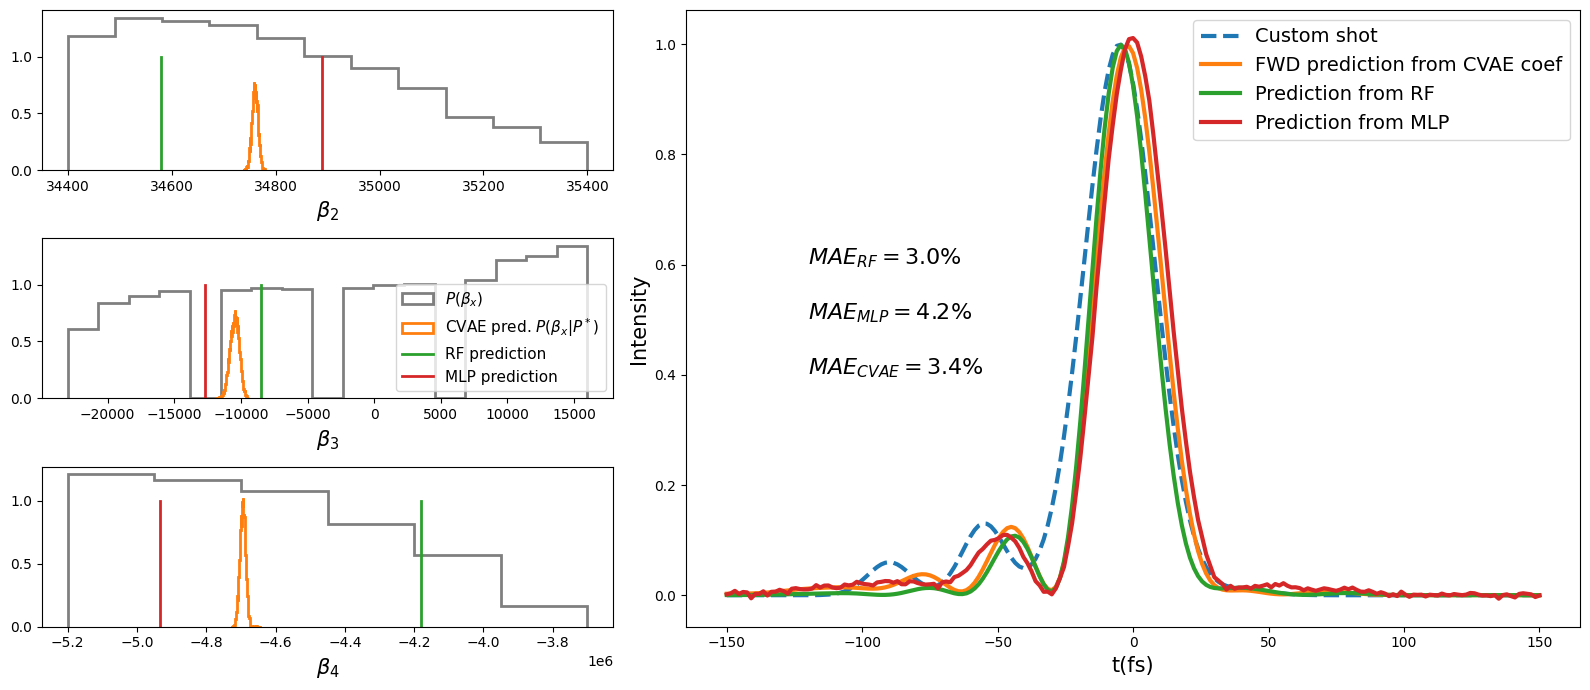

In [32]:
y_cust_shot=func(t_200,
                 0.06,-90,8,
                 0.13,-55,8,
                 1,-5,13,
                 0.01,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)

/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/javierhn/venv_galadriel/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PREDICTIONS:
*Random Forest:
 -Order2: 34620.0
 -Order3: -3370.0
 -Order4: -4371000.0
*MLP:
 -Order2: 34397.188
 -Order3: 900.35144
 -Order4: -4517344.5
*CVAE:
 -Order2: 34532.62
 -Order3: -2532.4514
 -Order4: -4568411.0


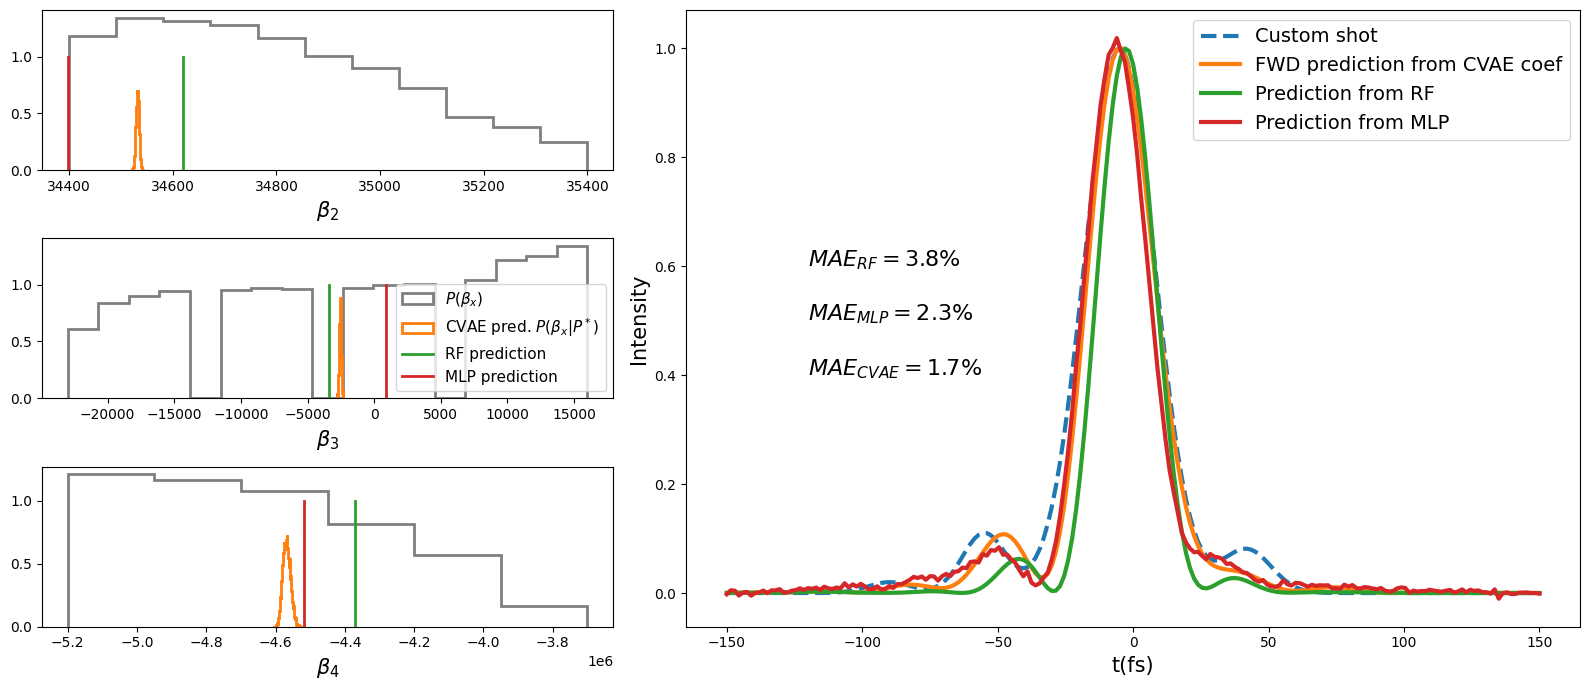

In [33]:
y_cust_shot=func(t_200,
                 0.02,-90,8,
                 0.11,-55,8,
                 1,-5,13,
                 0.08,+42,9,
                 0.00,+90,8)

pred_cust_cvae(y_cust_shot,model_cvae,forward_model_rf,
                   roundmodel_rf,roundmodel_mlp,
                   df_input_reduced,t_200,X_train,device)